# High School Graduation Rates – Montgomery County, MD

**Nick Schaap**

**CMSC320** | *Spring 2022*

## Background

Growing up in Montgomery County, MD, I have first-hand knowledge of some of the biggest issues faced by my county's school district. MCPS is the 14th largest public school district in the US by enrollment. It is also extremely diverse. Its 165,000+ students comprise more than 150+ countries and speak more than 150 languages (https://www.montgomeryschoolsmd.org/about/). One of the biggest issues faced by MCPS is the achievement gap. Currently, there exist large discrepancies in educational outcomes across MCPS's 15 high school clusters. This can largely be attributed to various external factors such as income level and other environmental factors. I wanted to examine specifically the correlation between crime and key school profile information such as graduation rate, attendance rate, reduced lunch program rates, and student to staff ratios.

In [201]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from fuzzywuzzy import fuzz
import geopy.distance

## Data Collection

I wanted to collect both graduation rate and other profile information for each high school as well as crime data. The crime data dated as far back as 2013. Thus, I retrieved school profile information from 2013-2021. I will be focusing my analysis during this time frame as this is when I was able to find data. I used the MCPS website to collect school at a glance information from 2013-2021. The data is tabulated in pdf form so I quickly copied and pasted the data into an excel sheet and exported it as a CSV. Then I used pandas to do some data reformatting and parse the values for each school and year.

In [175]:
schools_at_a_glance = "http://ww2.montgomeryschoolsmd.org/depArtments/sharedaccountability/glance/"
school_data.head()

,Year,High School,OTHER CLASS SIZE,ENG CLASS SIZE,STUD/STAFF RATIO,MOBILITY,DROPOUT,GRADUATION,ATTENDANCE,FARMS,latitude,longitude
214,2013,Thomas Edison HS,18.1,65.1,--,--,76.1,70.7,Technology,of,39.025392,-77.130102
188,2014,Thomas Edison HS,6.0,--,--,--,--,72.1,Technology,of,39.025392,-77.130102
138,2016,Gaithersburg HS,14.3,14.1,10.3,19.2,17.1,74.0,86.8,75.2,39.134839,-77.195478
112,2017,Gaithersburg HS,14.3,14.1,10.3,19.2,17.1,74.0,86.8,75.2,39.134839,-77.195478
60,2019,Gaithersburg HS,14.3,14.1,10.3,19.2,17.1,74.0,86.8,75.2,39.134839,-77.195478


In [212]:
school_data = pd.read_csv('school_data.csv')
school_data = school_data.melt(var_name="Year", value_name="Value")
for (i, row) in school_data.iterrows():
    values = row['Value'].split()
    school_data.at[i, 'High School'] = " ".join(values[0:(len(values) - len(columns))])
    columns = ['FARMS', 'ATTENDANCE', 'GRADUATION', 'DROPOUT', 'MOBILITY', 'STUD/STAFF RATIO', 'ENG CLASS SIZE', 'OTHER CLASS SIZE']
    for j in range(0, len(columns)):
        school_data.at[i, columns[-(j+1)]] = values[-(j+1)]
school_data = school_data.drop(columns=['Value'])

def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False

school_data['GRADUATION'] = school_data['GRADUATION'].apply(lambda x:  float(x) if x[0].isdigit() else float(x[1:]) if containsNumber(x) else -1)
school_data = school_data[school_data['GRADUATION'] > 0]

school_data['FARMS'] = school_data['FARMS'].apply(lambda x:  float(x) if x[0].isdigit() else float(x[1:]) if containsNumber(x) else -1)
school_data = school_data[school_data['FARMS'] > 0]

school_data['DROPOUT'] = school_data['DROPOUT'].apply(lambda x:  float(x) if x[0].isdigit() else float(x[1:]) if containsNumber(x) else -1)
school_data = school_data[school_data['DROPOUT'] > 0]

schools_info = pd.read_json('https://data.montgomerycountymd.gov/resource/7ycz-azby.json')

for (i, row) in school_data.iterrows():
    school_name = row["High School"]
    find_school = schools_info.copy(deep=True)
    find_school['match_score'] = find_school.apply(lambda x: fuzz.partial_ratio(school_name, x["school_name"]), axis=1)
    find_school = find_school.sort_values(by='match_score', ascending=False).head(1).index.values[0]
    school_data.at[i, "school_info_index"] = find_school
school_data = school_data.astype({'school_info_index':'int'})
school_data

,Year,High School,OTHER CLASS SIZE,ENG CLASS SIZE,STUD/STAFF RATIO,MOBILITY,DROPOUT,GRADUATION,ATTENDANCE,FARMS,school_info_index
0,2021,Bethesda-Chevy Chase HS,17.6,14.6,15.1,7.7,5.0,92.7,93.4,21.7,1
1,2021,Montgomery Blair HS,21.1,20.2,13.3,10.0,8.2,88.2,90.5,51.2,20
2,2021,James Hubert Blake HS,19.0,16.1,13.4,9.7,5.0,92.1,92.3,56.3,23
3,2021,Winston Churchill HS,22.9,19.4,12.3,≤5.0,5.0,95.0,93.8,8.4,7
4,2021,Clarksburg HS,16.7,17.9,13.2,10.7,5.0,93.2,93.0,44.8,11
...,...,...,...,...,...,...,...,...,...,...,...
229,2013,Springbrook HS,25.9,25.6,12.1,13.9,8.9,83.3,93.1,65.6,22
230,2013,Watkins Mill HS,23.8,24.2,10.5,18.6,7.6,83.5,91.5,71.7,17
231,2013,Wheaton HS,23.4,22.6,9.8,17.9,13.4,74.1,92.4,79.9,24
232,2013,Walt Whitman HS,25.7,25.0,12.5,8.3,5.0,95.0,94.8,5.0,2


I also pulled school location information to be able to find geographically where schools were located within the county.

I obtained crime data from the Montgomery County, Maryland open data archive. This data dates back to 2013 and contains over 234,000 crime records.

,Year,High School,OTHER CLASS SIZE,ENG CLASS SIZE,STUD/STAFF RATIO,MOBILITY,DROPOUT,GRADUATION,ATTENDANCE,FARMS,school_info_index
0,2021,Bethesda-Chevy Chase HS,17.6,14.6,15.1,7.7,≤5.0,92.7,93.4,21.7,1
1,2021,Montgomery Blair HS,21.1,20.2,13.3,10.0,8.2,88.2,90.5,51.2,20
2,2021,James Hubert Blake HS,19.0,16.1,13.4,9.7,≤5.0,92.1,92.3,56.3,23
3,2021,Winston Churchill HS,22.9,19.4,12.3,≤5.0,≤5.0,95.0,93.8,8.4,7
4,2021,Clarksburg HS,16.7,17.9,13.2,10.7,≤5.0,93.2,93.0,44.8,11
...,...,...,...,...,...,...,...,...,...,...,...
229,2013,Springbrook HS,25.9,25.6,12.1,13.9,8.9,83.3,93.1,65.6,22
230,2013,Watkins Mill HS,23.8,24.2,10.5,18.6,7.6,83.5,91.5,71.7,17
231,2013,Wheaton HS,23.4,22.6,9.8,17.9,13.4,74.1,92.4,79.9,24
232,2013,Walt Whitman HS,25.7,25.0,12.5,8.3,≤5.0,95.0,94.8,≤5.0,2


In [93]:
crime_data = pd.read_json("https://data.montgomerycountymd.gov/resource/icn6-v9z3.json?$limit=300000&$order=date")
crime_data

,incident_id,offence_code,case_number,date,nibrs_code,victims,crimename1,crimename2,crimename3,district,...,address_street,street_type,start_date,end_date,latitude,longitude,police_district_number,geolocation,street_prefix_dir,street_suffix_dir
0,201128049,2305,170500004,2017-04-02 07:37:54,23F,1,Crime Against Property,Theft From Motor Vehicle,LARCENY - FROM AUTO,SILVER SPRING,...,BONIFANT,ST,2017-04-01T21:00:00.000,2017-04-02T07:22:00.000,38.993394,-77.027988,3D,"{'latitude': '38.9934', 'longitude': '-77.028'...",NaN,NaN
1,201128044,2305,170500000,2017-04-02 07:41:50,23F,1,Crime Against Property,Theft From Motor Vehicle,LARCENY - FROM AUTO,WHEATON,...,BUCKNELL,DR,2017-04-02T09:39:00.000,NaN,39.043166,-77.046085,4D,"{'latitude': '39.0432', 'longitude': '-77.0461...",NaN,NaN
2,201128146,5499,170500005,2017-04-02 08:12:11,90Z,1,Other,NOT NIBRS CODE,TRAFFIC OFFENSES (DESCRIBE OFFENSE),MONTGOMERY VILLAGE,...,BRINK,RD,2017-04-02T08:12:00.000,2017-04-02T08:13:00.000,39.200899,-77.193432,6D,"{'latitude': '39.2009', 'longitude': '-77.1934...",NaN,NaN
3,201128140,2308,170500003,2017-04-02 08:18:29,23D,1,Crime Against Property,Theft from Building,LARCENY - FROM BLDG,SILVER SPRING,...,WEST,HWY,2017-04-02T08:18:00.000,NaN,38.993620,-77.032340,3D,"{'latitude': '38.9936', 'longitude': '-77.0323...",E,NaN
4,201128050,2404,170500009,2017-04-02 09:36:31,240,1,Crime Against Property,Motor Vehicle Theft,AUTO THEFT - VEHICLE THEFT,SILVER SPRING,...,DOMER,AVE,2017-04-02T00:00:00.000,2017-04-02T09:24:00.000,38.996873,-77.000292,3D,"{'latitude': '38.9969', 'longitude': '-77.0003...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294057,201322579,1103,210008857,NaT,11A,1,Crime Against Person,Forcible Rape,RAPE - STRONG-ARM,GERMANTOWN,...,DAVENTRY,WAY,2020-12-01T10:23:00.000,2020-12-31T00:00:00.000,39.156742,-77.278622,5D,"{'latitude': '39.1567', 'longitude': '-77.2786...",NaN,NaN
294058,201331625,1114,200050698,NaT,11B,1,Crime Against Person,Forcible Sodomy,SEX ASSAULT - SODOMY-GIRL-STRONG-ARM,WHEATON,...,EWOOD,LA,2020-11-01T15:00:00.000,2021-01-06T15:00:00.000,39.070376,-77.048437,4D,"{'latitude': '39.0704', 'longitude': '-77.0484...",NaN,NaN
294059,201323218,2399,210009607,NaT,23H,1,Crime Against Property,All other Larceny,LARCENY (DESCRIBE OFFENSE),SILVER SPRING,...,CASTLE,BLV,2021-02-20T00:00:00.000,2021-02-20T23:59:00.000,39.086323,-76.940087,3D,"{'latitude': '39.0863', 'longitude': '-76.9401...",NaN,NaN
294060,201326306,2305,210012653,NaT,23F,1,Crime Against Property,Theft From Motor Vehicle,LARCENY - FROM AUTO,MONTGOMERY VILLAGE,...,FREDERICK,AVE,2021-03-06T06:27:00.000,2021-04-05T00:00:00.000,39.157637,-77.217996,6D,"{'latitude': '39.1576', 'longitude': '-77.218'...",N,NaN


In [94]:
crimes_against_people = crime_data[crime_data['crimename1'].str.contains("Property", na=False)]
crimes_family_offenses = crime_data[crime_data['nibrs_code'].str.contains('90F', na=False)]
print(crimes_family_offenses['crimename2'].unique())
print(crimes_family_offenses['crimename3'].unique())
# map_osm = folium.Map(location=[39.1547, -77.2405], zoom_start=11, tiles = "Stamen Toner")
# for index, school in schools_info.iterrows():
#     if school["category"] == "HIGH SCHOOLS":
#         folium.Marker(location=[school["latitude"], school["longitude"]], tooltip=school["school_name"],
#                     icon=folium.Icon(color='red')).add_to(map_osm)
# heat_data = [[row['latitude'],row['longitude']] for _, row in crimes_against_people.iterrows()]
# HeatMap(heat_data, radius=15).add_to(map_osm)
# map_osm

['Family Offenses, NonViolent']
['FAMILY OFFENSE - NEGLECT CHILD (INCLUDES NONSUPPOR'
 'FAMILY OFFENSE - NEGLECT FAMILY' 'FAMILY OFFENSE (DESCRIBE OFFENSE)'
 'FAMILY OFFENSE - CRUELTY TOWARD CHILD'
 'FAMILY OFFENSE - CRUELTY TOWARD WIFE']


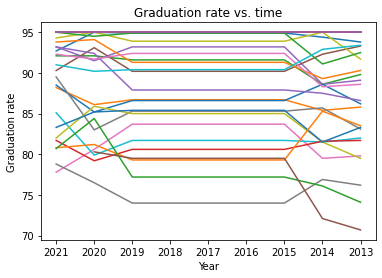

In [95]:
for school in school_data['High School'].unique():
    school_info = school_data[school_data['High School'] == school]
    plt.plot(school_info['Year'], school_info["GRADUATION"], label=school)
    plt.title('Graduation rate vs. time')
    plt.xlabel('Year')
    plt.ylabel('Graduation rate')
# plt.legend()
plt.show()

In [215]:
def get_crimes_near_school(school_name, nibrs_codes = None, mile_radius = 5):
    if nibrs_codes is not None:
        crimes = crime_data[crime_data['nibrs_code'].str.contains("|".join(nibrs_codes), na=False)]
    else:
        crimes = crime_data
    school = schools_info.loc[schools_info['school_name'] == school_name]
    school = school.copy().reset_index().iloc[0,:]
    location = tuple(school[["latitude", "longitude"]])
    crimes = crimes.copy(deep=True)
    for(i, row) in crimes.iterrows():
        crime_location = tuple(row[["latitude", "longitude"]])
        crimes.at[i, "near-school"] = geopy.distance.distance(location, crime_location).miles <= mile_radius
    return crimes[crimes["near-school"] == True]

average_school_rates = school_data.groupby(by=["High School", "school_info_index"]).mean().reset_index()
average_school_rates

for (i, row) in average_school_rates.iterrows():
    school_name = schools_info.iloc[row["school_info_index"]]["school_name"]
    crimes = get_crimes_near_school(school_name, nibrs_codes=['90F'])
    numCrimes = crimes["incident_id"].count()
    average_school_rates.at[i, "numCrimes"] = numCrimes
    
    
    

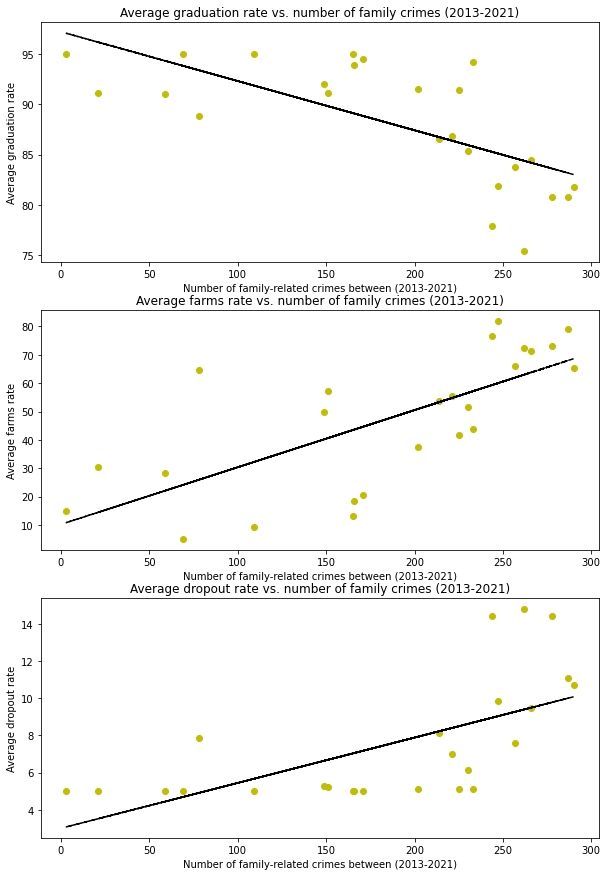

In [229]:
def plot_school_rates_vs_crime(rate, plt, label_min=None):
    x = average_school_rates["numCrimes"]
    y = average_school_rates[rate]
    schools = average_school_rates["High School"]
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
    for i, label in enumerate(schools):
        if label_min is not None and y[i] < label_min:
            plt.annotate(label, (x[i], y[i]))
    plt.set_title(f'Average {rate.lower()} rate vs. number of family crimes (2013-2021)')
    plt.set_xlabel('Number of family-related crimes between (2013-2021)')
    plt.set_ylabel(f'Average {rate.lower()} rate')
    # plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(10, 15)
plot_school_rates_vs_crime("GRADUATION", ax1)
plot_school_rates_vs_crime("FARMS", ax2)
plot_school_rates_vs_crime("DROPOUT", ax3)
fig.
fig.show()